<a href="https://colab.research.google.com/github/emmayeh-0211/2021AI_dl/blob/main/vessel_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import imgaug.augmenters as iaa
import imgaug as ia
from tensorflow.keras import *
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
import pandas as pd

#### Download data

In [2]:
# download dataset from https://drive.google.com/file/d/1JILW10sr40CRTLiuA1mf__5GBtMDF9xc/view?usp=sharing
!gdown --id 1JILW10sr40CRTLiuA1mf__5GBtMDF9xc --output vessel_seg.zip

Downloading...
From: https://drive.google.com/uc?id=1JILW10sr40CRTLiuA1mf__5GBtMDF9xc
To: /content/vessel_seg.zip
29.2MB [00:00, 70.6MB/s]


In [3]:
# unzip file
!unzip -q vessel_seg.zip

#### Data Analysis

In [4]:
# read img and mask
img_paths = glob('all/train/*.tif')
img_path = np.random.choice(img_paths, size=1)[0]
mask_path = img_path.replace('_training.tif', '_manual1.gif')

print('img path: ', img_path)
print('mask path:',  mask_path)

img = cv2.imread(img_path)[:, :, ::-1]
mask = Image.open(mask_path)
mask = np.array(mask)

img path:  all/train/34_training.tif
mask path: all/train/34_manual1.gif


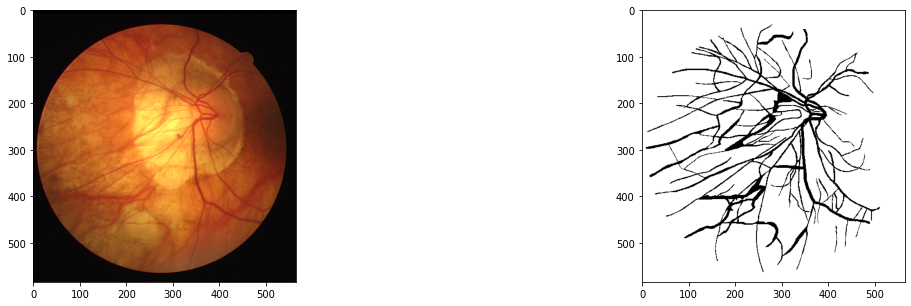

In [6]:
# show image
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(mask, cmap='gray_r')
plt.show()

In [7]:
img.shape, mask.shape

((584, 565, 3), (584, 565))

#### Data processing

In [8]:
IMG_SIZE = 512
BS = 4

In [10]:
class DataGenerator(utils.Sequence):
    def __init__(self, img_paths, batch_size, img_size, shuffle=True, mode='train', aug=False):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.img_size = img_size
        self.mode = mode
        self.img_paths = img_paths
        self.mask_paths = [p.replace('_training.tif', '_manual1.gif') for p in self.img_paths]
        self.aug = aug
        self.indexes = np.arange(len(self.mask_paths))
        self.seq = iaa.Sequential([
            iaa.Fliplr(0.5), # 50% horizontal flip
            iaa.Flipud(0.5),
            iaa.Affine(
                rotate=(90, -90), # random rotate -45 ~ +45 degree
                shear=(-3,3), # random shear -16 ~ +16 degree
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)} # scale x, y: 80%~120%
            ),
        ])
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.mask_paths) / self.batch_size)) # batches per epoch

    def __getitem__(self, index):
        # Generate indexes of the batch
        idxs = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Find list of IDs
        batch_img_paths = [self.img_paths[i] for i in idxs]
        batch_mask_paths = [self.mask_paths[i] for i in idxs]

        # Generate data
        X, y = self.__data_generation(batch_img_paths, batch_mask_paths)
        if self.mode != 'test':
            return X, y
        else:
            return X

    def on_epoch_end(self):
        # Updates indexes after each epoch
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, img_paths, mask_paths):
        # Generates data containing batch_size samples
        x = np.empty((len(img_paths), self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.empty((len(img_paths), self.img_size, self.img_size, 1), dtype=np.float32)

        for i, (img_path, mask_path) in enumerate(zip(img_paths, mask_paths)):
            img = cv2.imread(img_path)[:, :,::-1]
            img = self.preprocess(img)
            x[i] = img
            if self.mode != 'test':
                mask = np.array(Image.open(mask_path))
                mask = self.preprocess(mask)
                y[i] = np.expand_dims(mask, axis=-1)
        if self.aug:
            x, y = self.seq(images=x, heatmaps=y)
        return x, y

    def preprocess(self, img):
        data = cv2.resize(img, (self.img_size, self.img_size))
        data = data / 255. # normalize to 0~1
        return data

In [11]:
all_paths = glob('all/train/*.tif')
test_paths = sorted(glob('all/test/*.tif'))
train_paths, val_paths = train_test_split(all_paths, test_size=0.2)

train_gen = DataGenerator(train_paths, BS, IMG_SIZE, shuffle=True, mode='train', aug=True)
val_gen = DataGenerator(val_paths, BS, IMG_SIZE, shuffle=False, mode='val')
test_gen = DataGenerator(test_paths, BS, IMG_SIZE, shuffle=False, mode='test')

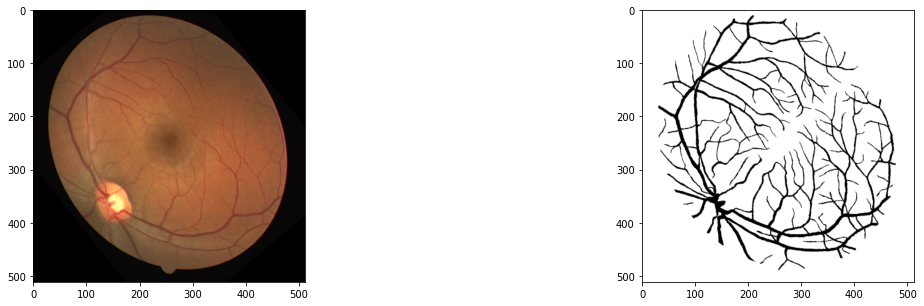

In [14]:
# Check output

batch_x, batch_y = train_gen[0]

batch_i = np.random.choice(len(batch_x))
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.imshow(batch_x[batch_i], cmap='gray_r')
plt.subplot(1,2,2)
plt.imshow(batch_y[batch_i, :, :, 0], cmap='gray_r')
plt.show()

#### Build model

In [20]:
def conv_bn(x, filters):
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

input_layer = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = conv_bn(input_layer, 8)
c1 = conv_bn(x, 8)
x = layers.MaxPool2D(strides=(2,2))(c1)
x = conv_bn(x, 16)
c2 = conv_bn(x, 16)
x = layers.MaxPool2D(strides=(2,2))(c2)
x = conv_bn(x, 32)
c3 = conv_bn(x, 32)
x = layers.MaxPool2D(strides=(2,2))(c3)
x = conv_bn(x, 64)
c4 = conv_bn(x, 64)

x = layers.concatenate([layers.UpSampling2D(size=(2,2))(c4), c3], axis=-1)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = layers.concatenate([layers.UpSampling2D(size=(2,2))(x), c2], axis=-1)
x = conv_bn(x, 64)
x = conv_bn(x, 64)
x = layers.concatenate([layers.UpSampling2D(size=(2,2))(x), c1], axis=-1)
x = conv_bn(x, 128)
x = conv_bn(x, 128)

output_layer = layers.Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(x)
                                                         
model = models.Model(input_layer, output_layer)

In [21]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 512, 512, 8)  224         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 512, 512, 8)  32          conv2d_30[0][0]                  
__________________________________________________________________________________________________
re_lu_28 (ReLU)                 (None, 512, 512, 8)  0           batch_normalization_28[0][0]     
____________________________________________________________________________________________

In [ ]:
utils.plot_model(model, show_shapes=True)

#### Training

骰子係數（Dice coefficient），是一種集合相似度度量函數，通常用於計算兩個樣本的相似度

In [22]:
# Customize Dice coefficient
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true) # 把正確答案攤平
    y_pred_f = K.flatten(y_pred)  # 把predict答案也攤平
    intersection = K.sum(y_true_f * y_pred_f) #再看他們的交集
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon()) # 1e-6, 1e-7

In [23]:
model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=[dice_coef])

In [24]:
weight_saver = callbacks.ModelCheckpoint('seg.h5', monitor='val_loss', save_best_only=True)
earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=100)

In [25]:
logs = model.fit(train_gen,
                 validation_data = val_gen,
                 epochs=1000,
                 callbacks = [weight_saver, earlystop])

Epoch 1/1000
4/4 [==============================] - 41s 608ms/step - loss: 0.6768 - dice_coef: 0.1649 - val_loss: 0.6772 - val_dice_coef: 0.1557
Epoch 2/1000
4/4 [==============================] - 2s 482ms/step - loss: 0.3546 - dice_coef: 0.1676 - val_loss: 0.6474 - val_dice_coef: 0.1539
Epoch 3/1000
4/4 [==============================] - 2s 479ms/step - loss: 0.2735 - dice_coef: 0.1735 - val_loss: 0.6098 - val_dice_coef: 0.1517
Epoch 4/1000
4/4 [==============================] - 2s 480ms/step - loss: 0.2438 - dice_coef: 0.1858 - val_loss: 0.5628 - val_dice_coef: 0.1470
Epoch 5/1000
4/4 [==============================] - 2s 480ms/step - loss: 0.2283 - dice_coef: 0.2216 - val_loss: 0.5359 - val_dice_coef: 0.1449
Epoch 6/1000
4/4 [==============================] - 2s 482ms/step - loss: 0.2254 - dice_coef: 0.2328 - val_loss: 0.6035 - val_dice_coef: 0.1529
Epoch 7/1000
4/4 [==============================] - 2s 482ms/step - loss: 0.2111 - dice_coef: 0.2691 - val_loss: 0.5787 - val_dice_coef

KeyboardInterrupt: ignored

#### Evaluate

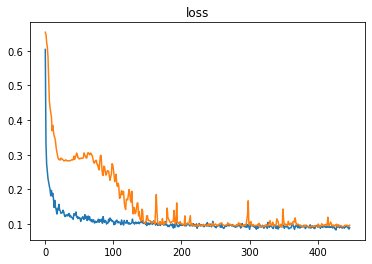

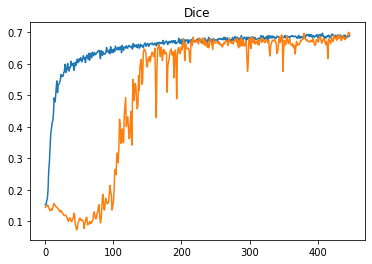

In [ ]:
history = logs.history
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('loss')
plt.show()
plt.plot(history['dice_coef'])
plt.plot(history['val_dice_coef'])
plt.title('Dice')
plt.show()

In [26]:
model_final = models.load_model('seg.h5', compile=False)

0


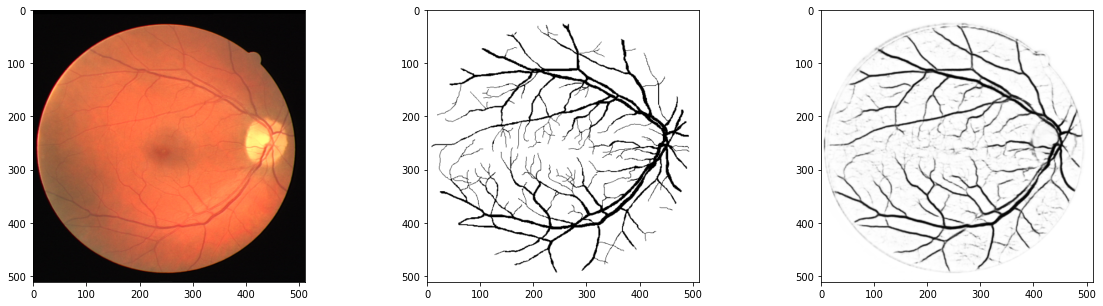

In [27]:
# Sample 1 batch
batch_idx = np.random.randint(len(val_gen))
print(batch_idx)
data = val_gen[batch_idx]
imgs, mask = data # (bs, 512, 512, 3), (bs, 512, 512, 1)
mask_pred = model_final.predict(imgs)

# show inputs
img_idx = np.random.randint(len(imgs)) # sample 1 image from batch
plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
plt.imshow(imgs[img_idx])

# show ground truth & model prediction
plt.subplot(1, 3, 2)
plt.imshow(mask[img_idx, :, :, 0], cmap='gray_r')
plt.subplot(1, 3, 3)
plt.imshow(mask_pred[img_idx, :, :, 0], cmap='gray_r')
plt.show()
# plt.imshow(mask_pred[img_idx, :, :, 0], cmap='gray')

In [28]:
# Displayed with different threshold
mask_pred_raw = mask_pred[img_idx, :, :, 0]
mask_pred_raw

array([[0.02452922, 0.01490205, 0.01142817, ..., 0.00938654, 0.01262447,
        0.0194975 ],
       [0.01160561, 0.00547277, 0.0041548 , ..., 0.00238651, 0.00406553,
        0.01010927],
       [0.00960109, 0.00376551, 0.00312843, ..., 0.00160357, 0.00295767,
        0.00905978],
       ...,
       [0.01139885, 0.00481887, 0.00487674, ..., 0.00269837, 0.00438118,
        0.01191861],
       [0.0126349 , 0.00550145, 0.00433083, ..., 0.00260394, 0.00415595,
        0.0123999 ],
       [0.02075095, 0.0106318 , 0.00832134, ..., 0.00559906, 0.00787085,
        0.01690985]], dtype=float32)

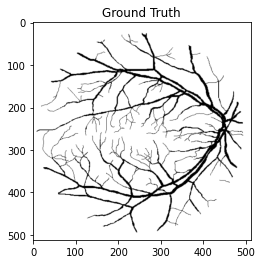

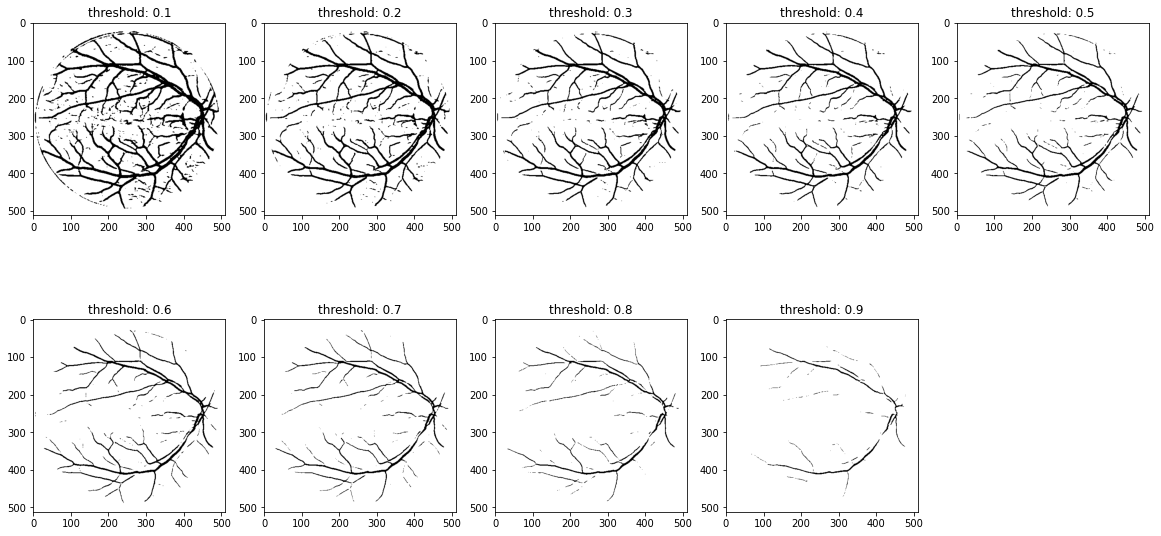

In [31]:
plt.imshow(mask[img_idx, :, :, 0], cmap='gray_r')
plt.title('Ground Truth')
plt.show()

plt.figure(figsize=(20, 10))
for i in range(1, 10):
    plt.subplot(2, 5, i)
    threshold = i * 0.1
    mask_threshold = mask_pred_raw.copy()
    mask_threshold[mask_threshold <= threshold] = 0.
    mask_threshold[mask_threshold > threshold] = 1.
    plt.imshow(mask_threshold, cmap='gray_r')
    plt.title(f'threshold: {threshold:.1f}')
plt.show()

In [32]:
# make prediction
threshold = 0.5
outputs = []
for i in range(len(test_gen)):
    x_test = test_gen[i]
    y_preds = model_final.predict(x_test)
    y_preds[y_preds <= threshold] = 0
    y_preds[y_preds > threshold] = 1
    for y_pred in y_preds:
        dots = np.where(y_pred.flatten() == 1)[0]
        run_lengths = []
        prev = -2
        for b in dots:
            if (b > prev +1):
                run_lengths.extend((b+1,0))
            run_lengths[-1] += 1
            prev = b
        output = ' '.join([str(r) for r in run_lengths])
        outputs.append(output)

In [33]:
df = pd.DataFrame(columns=['Id', 'Predicted'])
df['Id'] = [str(i) for i in range(20)]
df['Predicted'] = outputs
df.to_csv('submission.csv', index=None)
df

,Id,Predicted
0,0,15613 6 16115 34 16614 3 16618 11 16631 1 1664...
1,1,14608 4 15121 4 16130 2 16641 5 17130 5 17154 ...
2,2,14629 2 15664 6 16177 4 18127 1 18639 1 19150 ...
3,3,14584 3 15096 4 15609 4 15666 1 16122 3 16635 ...
4,4,16676 2 17188 3 19234 2 19746 2 20257 3 20768 ...
5,5,17155 2 17667 2 18213 3 18725 6 19239 6 19753 ...
6,6,17123 8 17160 9 17635 11 17674 8 18150 10 1819...
7,7,16617 3 17129 4 17642 5 18155 5 18193 1 18669 ...
8,8,14101 4 14616 1 15638 2 16114 3 16131 14 16147...
9,9,17665 1 18138 2 18177 2 18650 4 18690 1 19162 ...


In [34]:
aaa = np.zeros(shape=(128, 128, 1))

In [35]:
bbb = K.flatten(aaa)

In [36]:
bbb

<tf.Tensor: shape=(16384,), dtype=float64, numpy=array([0., 0., 0., ..., 0., 0., 0.])>